In [2]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import scrapy
from IPython.display import display
import csv
from pathlib import Path

In [8]:
# load data from excel file
df = pd.read_excel('../data/Export Inhaltsverzeichnis.xlsx', header = None)

# display data
df.head(25)

,0
0,---------------------------------------------...
1,001 # 990004744040602884
2,020 # a 978-3-487-15122-9
3,084 # 2 zU_GE # a MB 2500
4,"084 # 2 ssgn # a 9,2"
5,084 # 2 rvk # a LR 56000
6,084 # a S:an
7,084 # a S:mu
8,"100 1 # 0 (DE-588)124927785 # a Gruhn, Wil..."
9,245 1 0 # a Musikalische Gestik : # b vom mu...


In [9]:
# select rows that contain elements from searchfor

#searchfor = ['100 ','245 ', '# 2 rvk', '2 zU_', 'Inhaltstext','-----']
searchfor = ['100 ','245 ', '# 2 rvk', 'Inhaltstext','-----']
df_cleared = df[df[df.columns[0]].str.contains('|'.join(searchfor))]

# display cleared data
df_cleared.head(7)

,0
0,---------------------------------------------...
5,084 # 2 rvk # a LR 56000
8,"100 1 # 0 (DE-588)124927785 # a Gruhn, Wil..."
9,245 1 0 # a Musikalische Gestik : # b vom mu...
11,856 4 2 # 3 Inhaltstext # m X:MVB # q text/h...
13,---------------------------------------------...
17,084 # 2 rvk # a LI 99999


In [10]:
def get_ID(x):
    ''' extract ID from string '''
    return x.strip()[:3]

def get_remainder(x):
    ''' keep rest of string '''
    return x.strip()[4:].strip()


# get ID ; apply applies function to entire column
df_cleared['ID'] = df_cleared[0].apply(get_ID)
# get everything else
df_cleared['remainder'] = df_cleared[df.columns[0]].apply(get_remainder)
# resets index from 0, 4, 11, ... (random) to 0,1,2, ...
df_cleared.reset_index(inplace=True,drop=True)
# choose columns ID and remainder
df_cleared = df_cleared[['ID','remainder']]
# display edited dataframe
df_cleared.head(7)

C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,ID,remainder
0,---,----------------------------------------------...
1,084,# 2 rvk # a LR 56000
2,100,"1 # 0 (DE-588)124927785 # a Gruhn, Wilfried..."
3,245,1 0 # a Musikalische Gestik : # b vom musikal...
4,856,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...
5,---,----------------------------------------------...
6,084,# 2 rvk # a LI 99999


In [11]:
# get a list of indices of rows which seperate DataFrame with ---
# above 0, 4, ...
splits = list(df_cleared.loc[df_cleared['ID']=='---'].index)
print(splits[0:7])

[0, 5, 9, 12, 18, 26, 29]


In [12]:
# example of how to get a small DataFrame from the splits
partition = 0
df_cleared.loc[splits[partition]+1:splits[partition+1]-1]

,ID,remainder
1,084,# 2 rvk # a LR 56000
2,100,"1 # 0 (DE-588)124927785 # a Gruhn, Wilfried..."
3,245,1 0 # a Musikalische Gestik : # b vom musikal...
4,856,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...


In [13]:
# list to save DataFrames
dfs = []
# iterate over all splits to get all DataFrames
for partition in range(len(splits)-1):
    #print(partition,splits[partition]+1,splits[partition+1]-1)
    #print()
    dfs.append(df_cleared.loc[splits[partition]+1:splits[partition+1]-1])

# print example from list
dfs[1]

,ID,remainder
6,084,# 2 rvk # a LI 99999
7,245,0 0 # a Aernout Mik Communitas : # b Jeu de P...
8,856,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...


In [14]:
# seems to appear twice

# iterate over all splits to get all DataFrames
#for partition in range(len(splits)-1):
#    #print(partition,splits[partition]+1,splits[partition+1]-1)
#    #print()
#    dfs.append(df_cleared.loc[splits[partition]+1:splits[partition+1]-1])
#
# print example from list
#dfs[1]

In [16]:
# example conversion - get it to "column format"
def extract_category(s):
    global classes
    cat = ''.join([c for c in s if c.isupper()])
    if cat in classes.keys():
        return classes[cat]
    else:
        return 'unmatched'
 
classes = pd.read_csv('../data/rvk_klassen.csv').set_index('ID').to_dict()['class']

df = dfs[10]
df = df.rename(columns={'remainder':123}).set_index('ID').T

temp = df["084"].values.tolist()
print(temp)

for i in range(len(temp[0])):
    temp[0][i] = extract_category(temp[0][i])
    # is the same as
    # temp[0][i] = ''.join([c for c in temp[0][i] if c.isupper()])
print(temp)

temp[0] = list(set(temp[0]))
print(temp)

df.drop(columns="084",inplace=True)
df["084"] = temp
df.head()

[['# 2 rvk # a CP 2500', '# 2 rvk # a UH 7400', '# 2 rvk # a LH 70080', '# 2 rvk # a LH 61346', '# 2 rvk # a LH 61342']]
[['Psychologie', 'Physik', 'Kunstgeschichte', 'Kunstgeschichte', 'Kunstgeschichte']]
[['Kunstgeschichte', 'Physik', 'Psychologie']]


ID,100,245,856,084
123,"1 # 0 (DE-588)115584897 # a Welsch, Norbert...","1 0 # a Farben : # b Natur, Technik, Kunst / ...",4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,"[Kunstgeschichte, Physik, Psychologie]"


In [17]:
# convert all samples to "column format"
def extract_category(s):
    global classes
    cat = ''.join([c for c in s if c.isupper()])
    if cat in classes.keys():
        return classes[cat]
    else:
        return 'unmatched'

classes = pd.read_csv('../data/rvk_klassen.csv').set_index('ID').to_dict()['class']


# loop over all dfs
for i in tqdm(range(len(dfs))):

    df_temp = dfs[i].rename(columns={'remainder':i}).set_index('ID').T

    if "084" in df_temp.columns:
        temp = df_temp["084"].values.tolist()
        #print(temp)

        # if only one 084 column is present
        if type(temp[0])==str:
            temp = [temp]


        for j in range(len(temp[0])):
            temp[0][j] = extract_category(temp[0][j])

        temp[0] = list(set(temp[0]))

        df_temp.drop(columns="084",inplace=True)
        df_temp["084"] = temp
    dfs[i] = df_temp


100%|███████████████████████████████████████████████████████████████████████████| 23680/23680 [03:00<00:00, 131.04it/s]


In [18]:
cntr = 0

# define starting dataframe
df_0 = dfs[0]

# iterate over all otheer DataFrames
for df in tqdm(dfs[1:]):
    try:
        # attach df to df_0
        df_0 = df_0.append(df)
    except:
        cntr += 1
        
print('skipped',cntr)

#df
df = df_0[['100','245','856','084']]

100%|████████████████████████████████████████████████████████████████████████████| 23679/23679 [05:15<00:00, 75.11it/s]

skipped 383


In [19]:
df.head(10)

,100,245,856,084
0,"1 # 0 (DE-588)124927785 # a Gruhn, Wilfried...",1 0 # a Musikalische Gestik : # b vom musikal...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,[Musikwissenschaft]
1,NaN,0 0 # a Aernout Mik Communitas : # b Jeu de P...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,[Kunstgeschichte]
2,NaN,0 0 # a Anton Henning : # b [anläßlich der Au...,4 2 # 3 Inhaltstext # q text/html # u http://...,NaN
3,"1 # 0 (DE-588)13168373X # a Specht, Heike #...",1 0 # a &lt;&lt;Die&gt;&gt; Feuchtwangers : #...,4 2 # 3 Inhaltstext # q text/html # u http://...,"[Geschichte, Sprachwissenschaften]"
4,"1 # 0 (DE-588)115202633 # a Scruton, Roger ...",1 0 # a Grüne Philosophie : # b ein konservat...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,"[Allgemeines, Theologie und Religionswissensch..."
5,NaN,"0 0 # a Ausbildung zum, zur Elektroniker-in. ...",4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,NaN
6,NaN,"0 0 # a Ausbildung zum, zur Elektroniker-in. ...",4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,NaN
7,NaN,0 0 # a Handwörterbuch des politischen System...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,[Politologie]
8,"1 # 0 (DE-588)1033015865 # a Schlagowski, H...",1 0 # a Technische Dokumentation im Maschinen...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,[Technik]
9,"1 # 0 (DE-588)132181541 # a Möller, Gerd",1 0 # a Geotechnik : # b Bodenmechanik / # c ...,4 2 # 3 Inhaltstext # m X:MVB # q text/html #...,[Technik]


C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


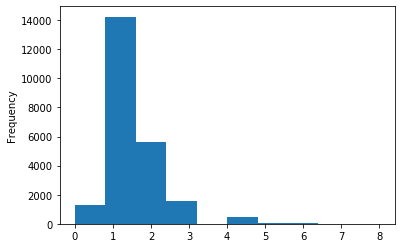

In [20]:
def get_number_of_cats(x):
    if type(x) == list:
        return len(x)
    elif np.isnan(x):
        return 0
    else:
        return 0
    
df['no_cats'] = df['084'].apply(get_number_of_cats)
df['no_cats'].plot(kind='hist')

In [21]:
def get_URL(text):
    ''' extract url from text '''
    urls = re.findall("((www\.|http://|https://)(www\.)*.*?(?=(www\.|http://|https://|$)))", text)
    urls2 = []
    for url in urls[0]:
        if 'htm' in url:
            urls2.append(url)
    try:
        return urls2[0]
    except:
        return ''
    
# extract url form column 856
df['URLs'] = df['856'].apply(get_URL) 
# check if url is easy scrapable
df['no_URLs'] = df['URLs'].apply(lambda x: 'deposit' in x)

C:\Users\Johannes\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
searchfor = ['vh-buchshop']
df = df[~df.URLs.str.contains('|'.join(searchfor))]

In [23]:
df100 = df['100'].str.split("# a ").str[-1].str.strip().str.split("# d ").str[0].str.strip()
df100 = pd.DataFrame(df100)
df100 = df100.join(df['084'])
df100.head(40)

,100,084
0,"Gruhn, Wilfried",[Musikwissenschaft]
1,NaN,[Kunstgeschichte]
2,NaN,NaN
3,"Specht, Heike","[Geschichte, Sprachwissenschaften]"
4,"Scruton, Roger","[Allgemeines, Theologie und Religionswissensch..."
7,NaN,[Politologie]
8,"Schlagowski, Heinz",[Technik]
9,"Möller, Gerd",[Technik]
10,"Welsch, Norbert","[Kunstgeschichte, Physik, Psychologie]"
11,NaN,[Philosophie]


In [24]:
df100.to_pickle('../data/df100.pkl')

In [25]:
df.loc[1:,"URLs":"URLs"].to_pickle('../data/urls.pkl')